In [1]:
#configure plotting
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams['figure.figsize'] = (16, 10)
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 25
matplotlib.rcParams['font.family'] = 'serif'

import GPy
import numpy as np
from matplotlib import pyplot as plt

np.random.seed(42)

from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import accuracy_score

import config
import Data

# Initialize experiment
- Train dataset size changes from start_n to end_n  
- Info about the experiment is saved at ./Results/name  
- draw_* options could be True only if ndim <= 2

In [2]:
info = config.ExperimentInfo(
    ndim_    = 3, 
    total_n_ = 2000, 
    start_n_ = 10, 
    end_n_   = 1000, 
    test_n_  = 1000, 
    name_    = "Skin",
    dataset_     = Data.Skin,
    draw_data_   = False,
    draw_scores_ = False,
    update_freq_ = 10,
    comparsion_  = True)

There are some needed variables. We aren't interested in them since we look into active learning part, not model charachteristics. Still the variables are needed to make it all work.

In [3]:
var = 100
lengthscale = 1

k = GPy.kern.RBF(info.ndim, variance = var, lengthscale = lengthscale)
lik = GPy.likelihoods.Bernoulli()

# An example Inference
To see whether gaussian process learns on the data

In [4]:
m = GPy.core.GP(
    X      = info.dataset.U,
    Y      = info.dataset.y_U.reshape(-1, 1), 
    kernel = k, 
    inference_method = GPy.inference.latent_function_inference.expectation_propagation.EP(),
    likelihood = lik)

m.optimize()
print(m.kern)

if (info.draw_data):
    m.plot(plot_density = True)

  rbf.         |               value  |  constraints  |  priors
  variance     |  120.15572720629046  |      +ve      |        
  lengthscale  |   54.77043774802837  |      +ve      |        


# Active learning part

In [5]:
import ScoreFunctions
import Utils

# this only needed if we want to compare active learning with traditional approaches

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

acc_lr = []
acc_kn = []
acc_dt = []
acc_rf = []

# The main loop
Train 6 gps with different score function

In [6]:
models = []

X_train_0   = info.dataset.X_train
y_train_0   = info.dataset.y_train
U_0         = info.dataset.U
y_U_0       = info.dataset.y_U

score_functions = [
    ScoreFunctions.calculate_scores_rand, 
    ScoreFunctions.calculate_scores_mvar,
    ScoreFunctions.calculate_scores_l2fm, 
    ScoreFunctions.calculate_scores_RKHS,
    ScoreFunctions.calculate_scores_Hvar]

for score in score_functions:
    info.dataset.X_train = X_train_0
    info.dataset.y_train = y_train_0
    info.dataset.U = U_0
    info.dataset.y_U = y_U_0
    
    k = GPy.kern.RBF(info.ndim, variance = var, lengthscale = lengthscale)
    m = GPy.core.GP(
        X      = info.dataset.X_train,
        Y      = info.dataset.y_train.reshape(-1, 1), 
        kernel = k, 
        inference_method = GPy.inference.latent_function_inference.expectation_propagation.EP(),
        likelihood = lik)
    
    K     = Utils.get_K(m, info.dataset.X_train)
    inv_K = Utils.get_inv_K(m, info.dataset.X_train) 
    
    score_name = str(score)[27:31]
    print(score_name)
    
    for i in tqdm(range(info.start_n, info.end_n)):
        # 0. learn GP on the data with update_frequency
        if i % info.update_freq == 0:
            m = GPy.core.GP(
                X      = info.dataset.X_train,
                Y      = info.dataset.y_train.reshape(-1, 1), 
                kernel = m.kern, 
                inference_method = GPy.inference.latent_function_inference.expectation_propagation.EP(),
                likelihood = lik)

            m.optimize(messages = False)
        
        # 1. calculate score at each point of the rest dataset in U and y_u, get the index of maximum score
        scores = score(np.array(info.dataset.U), m, info.dataset.X_train, info.dataset.y_train, inv_K)
        ind = np.argmax(scores)
        
        # 2. append new point to the training dataset and update inv_K
        info.dataset.X_train = np.concatenate(
            (info.dataset.X_train, 
             info.dataset.U[ind].reshape(-1, info.ndim)), 
            axis = 0)
        info.dataset.y_train = np.append(info.dataset.y_train, info.dataset.y_U[ind]).reshape(-1, 1)
        
        a = m.kern.K(
            info.dataset.U[ind].reshape(-1, info.ndim), 
            info.dataset.X_train[:info.dataset.X_train.shape[0]-1]).T
        
        inv_K = Utils.update_inv_K(m, info.dataset.X_train, inv_K, info.dataset.U[ind], a)
        
        # 2.5. draw score if needed
        # placing this function call right here is important
        # since draw_score should see whole U included the point to be deleted
        if info.draw_scores:
            info.dataset.draw_score(scores, score_name, info.name, i, m, score, inv_K)

        # 3. delete new point from U since it is labeled now
        info.dataset.U = np.delete(info.dataset.U, ind, axis = 0)
        info.dataset.y_U = np.delete(info.dataset.y_U, ind)

        # 4. count accuracy
        prediction = m.predict(info.dataset.X_test.reshape(-1, info.ndim))[:][0]
        cur_accuracy = accuracy_score(info.dataset.y_test, Utils.to_labels(prediction))
        
        info.per_score_acc[score_name].append(cur_accuracy)
        info.save(score_name)
        
        del a    
        del scores
        del prediction
        
        # 5. compare with other models
        # it is important to learn traditional methods on train dataset of rand score function
        if info.comparsion and score == ScoreFunctions.calculate_scores_rand:
            lr = LogisticRegression(solver = 'lbfgs').fit(info.dataset.X_train, info.dataset.y_train)
            acc_lr.append(lr.score(info.dataset.X_test, info.dataset.y_test))

            kn = KNeighborsClassifier().fit(info.dataset.X_train, info.dataset.y_train)
            acc_kn.append(kn.score(info.dataset.X_test, info.dataset.y_test))

            dt = DecisionTreeClassifier().fit(info.dataset.X_train, info.dataset.y_train)
            acc_dt.append(dt.score(info.dataset.X_test, info.dataset.y_test))

            rf = RandomForestClassifier().fit(info.dataset.X_train, info.dataset.y_train)
            acc_rf.append(rf.score(info.dataset.X_test, info.dataset.y_test))

            del lr
            del kn
            del dt
            del rf
        
    #after the gp is learned save it to models
    models.append(m)

rand


 /home/daria.kotova/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning:A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 /home/daria.kotova/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:91: DataConversionWarning:A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 /home/daria.kotova/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning:The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
 /home/daria.kotova/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:97: DataConversionWarning:A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
 /home/daria.kotova/anaconda2/lib/python2.7/site-packages/paramz/transformations.py:111


mvar



l2fm


 ScoreFunctions.py:83: RuntimeWarning:divide by zero encountered in divide
 ScoreFunctions.py:83: RuntimeWarning:invalid value encountered in divide
 ScoreFunctions.py:87: RuntimeWarning:invalid value encountered in multiply



RKHS



Hvar


 Utils.py:45: RuntimeWarning:divide by zero encountered in divide
 Utils.py:47: RuntimeWarning:invalid value encountered in multiply
 Utils.py:49: RuntimeWarning:invalid value encountered in multiply
 Utils.py:51: RuntimeWarning:invalid value encountered in multiply


# Analysis
- Plot gaussian processes if possible to see if there are alive  
- Plot accuracies (size of training dataset). Sqsm is exluded since we do not conduct experiments for this criterion

In [7]:
for m in models:
    print(m.kern)
    if info.draw_data:
        m.plot(plot_density = True)

  rbf.         |               value  |  constraints  |  priors
  variance     |   15328.73809092075  |      +ve      |        
  lengthscale  |  181.12131171801684  |      +ve      |        
  rbf.         |               value  |  constraints  |  priors
  variance     |   9970.291440988562  |      +ve      |        
  lengthscale  |  176.82836417831533  |      +ve      |        
  rbf.         |              value  |  constraints  |  priors
  variance     |  13750.02009265824  |      +ve      |        
  lengthscale  |  174.7493970751693  |      +ve      |        
  rbf.         |              value  |  constraints  |  priors
  variance     |  49681.90941836036  |      +ve      |        
  lengthscale  |  219.7700205892189  |      +ve      |        
  rbf.         |               value  |  constraints  |  priors
  variance     |   13562.43466623575  |      +ve      |        
  lengthscale  |  181.95208889521606  |      +ve      |        


In [8]:
acc_rand = np.loadtxt("./Results/" + info.name + "/accuracies/acc_rand.txt")
acc_mvar = np.loadtxt("./Results/" + info.name + "/accuracies/acc_mvar.txt")
acc_RKHS = np.loadtxt("./Results/" + info.name + "/accuracies/acc_RKHS.txt")
acc_Hvar = np.loadtxt("./Results/" + info.name + "/accuracies/acc_Hvar.txt")
acc_l2fm = np.loadtxt("./Results/" + info.name + "/accuracies/acc_l2fm.txt")
# acc_sqsm = np.loadtxt("./Results/" + info.name + "/accuracies/acc_sqsm.txt")

In [9]:
def Range(start, length, partition):
    return range(start, start + length // partition)

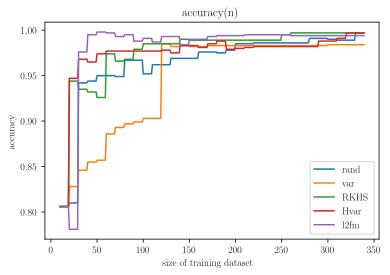

In [12]:
# first 1/partition of acc is shown
partition = 3

plt.plot(Range(info.start_n, len(acc_rand), partition), acc_rand[:len(acc_rand)//partition], label='rand')
plt.plot(Range(info.start_n, len(acc_mvar), partition), acc_mvar[:len(acc_mvar)//partition], label='var')
# plt.plot(Range(info.start_n, len(acc_sqsm), partition), acc_sqsm[:len(acc_sqsm)//partition], label='L2')
plt.plot(Range(info.start_n, len(acc_RKHS), partition), acc_RKHS[:len(acc_RKHS)//partition], label='RKHS')
plt.plot(Range(info.start_n, len(acc_Hvar), partition), acc_Hvar[:len(acc_Hvar)//partition], label='Hvar')
plt.plot(Range(info.start_n, len(acc_l2fm), partition), acc_l2fm[:len(acc_l2fm)//partition], label='l2fm')

# if info.comparsion:
#     plt.plot(Range(info.start_n, len(acc_lr), partition), acc_lr[:len(acc_lr)//partition], label='log. regression')
#     plt.plot(Range(info.start_n, len(acc_kn), partition), acc_kn[:len(acc_kn)//partition], label='k-nearest')
#     plt.plot(Range(info.start_n, len(acc_dt), partition), acc_dt[:len(acc_dt)//partition], label='decision tree')
#     plt.plot(Range(info.start_n, len(acc_rf), partition), acc_rf[:len(acc_rf)//partition], label='random forest')

plt.title("accuracy(n)")
plt.ylabel("accuracy")
plt.xlabel("size of training dataset")
plt.legend()
plt.savefig("./Results/" + info.name + "/accuracyGP" + str(partition) + ".png")